# week -3 : Model creation and evaluation

In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split as st
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns


## load dataset

In [8]:
df = pd.read_csv("processed_week2_data.csv")
df.shape


(68641, 17)

In [9]:
print(df['cardio'].value_counts(normalize=True))

cardio
0    0.505063
1    0.494937
Name: proportion, dtype: float64


In [10]:
df.head()

,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,BMI,high_bp,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,168,62.0,110,80,0,0,1,0,50,21.967120,0,True,False,False,True,False,False
1,156,85.0,140,90,0,0,1,1,55,34.927679,1,False,False,True,True,False,False
2,165,64.0,130,70,0,0,0,1,51,23.507805,0,False,False,True,True,False,False
3,169,82.0,150,100,0,0,1,1,48,28.710479,1,True,False,False,True,False,False
4,156,56.0,100,60,0,0,0,0,47,23.011177,0,True,False,False,True,False,False


## Spliting x and y 

In [11]:
from sklearn.model_selection import train_test_split

# stratify = y : class distribution same rese train and test ma

X = df.drop(['cardio'],axis=1)
y=df['cardio']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Feature scaling

In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train Logistic Regression Model

In [13]:
model = LogisticRegression(max_iter=5000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=5000)

## Make prediction

In [14]:
# predict_proba returns Probability
# [:1] select prob 1 

y_proba = model.predict_proba(X_test_scaled)[:,1]

# probability ne class 0 or 1 ma convert krse
y_pred = (y_proba >= 0.5).astype(int)   # now lower threshold


## Evaluate Model

In [15]:
acc = accuracy_score(y_test, y_pred)
# Accuracy= TP +TN /(TP+TN+FP+FN)

prec = precision_score(y_test, y_pred)
# Precision = TP / TP+FP

rec = recall_score(y_test, y_pred)
# Recall = TP / TP+FN
f1 = f1_score(y_test, y_pred)

# f1 = harmonic mean
# F1= Precision×Recall / 2×Precision+Recall
auc = roc_auc_score(y_test, y_proba)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)
print("ROC AUC  :", auc)


Accuracy : 0.7230679583363683
Precision: 0.7579727633166695
Recall   : 0.647093451066961
F1 Score : 0.6981581454429978
ROC AUC  : 0.7869707298054419


## Confusion matrix

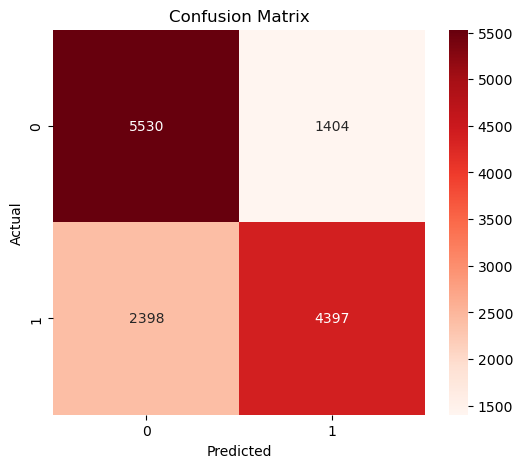

In [16]:
cm = confusion_matrix(y_test, y_pred)
# aaya fmt means Formate of Number and d means decimal
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## roc curve

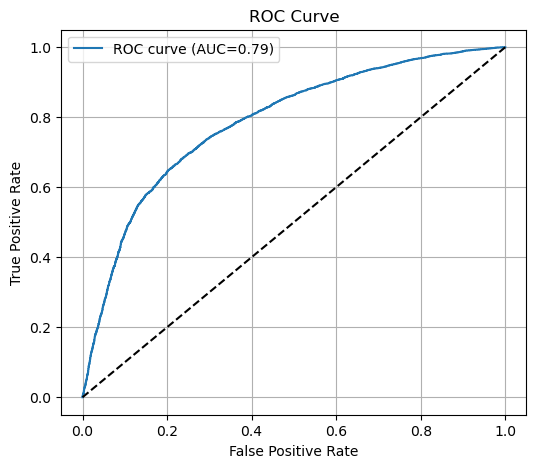

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


## Check Overfitting & Underfitting

In [18]:
y_train_pred = model.predict(X_train_scaled)

print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Test Accuracy  :", accuracy_score(y_test, y_pred))


Train Accuracy : 0.7298951048951049
Test Accuracy  : 0.7230679583363683


## Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

# Hyperparameters are settings chosen before training

param_grid = {
    "C": [0.1, 1, 5, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

logreg = LogisticRegression(max_iter=3000)

grid = GridSearchCV(logreg, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.7047396892845043


## train best model

In [20]:
best_model = grid.best_estimator_

y_best_pred = best_model.predict(X_test_scaled)
y_best_proba = best_model.predict_proba(X_test_scaled)[:,1]

print("New Tuned Accuracy:", accuracy_score(y_test, y_best_pred))
print("New Tuned F1 Score:", f1_score(y_test, y_best_pred))
print("New Tuned ROC AUC :", roc_auc_score(y_test, y_best_proba))


New Tuned Accuracy: 0.7231407968533761
New Tuned F1 Score: 0.6982135768161969
New Tuned ROC AUC : 0.7869716848842645


## save final dataset model

In [55]:
# import joblib

# joblib.dump(best_model, "best_logistic_model.pkl")
# joblib.dump(scaler, "scaler.pkl")

# print("Model & Scaler Saved Successfully!")


# Week - 4 :

In [21]:
import joblib

best_model_package = {
    "model": best_model,         # your final trained model
    "scaler": scaler,            # scaler used during training
    "features": list(X.columns)  # exact column order
}

joblib.dump(best_model_package, "cardio_model.pkl")
print("Single PKL Created Successfully!")


Single PKL Created Successfully!


In [22]:
print(X.columns)

Index(['height', 'weight', 'ap_hi', 'ap_lo', 'smoke', 'alco', 'active',
       'age_years', 'BMI', 'high_bp', 'cholesterol_1', 'cholesterol_2',
       'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3'],
      dtype='object')


In [17]:
low_risk_df = pd.DataFrame([{
    'height': 165,
    'weight': 60,
    'ap_hi': 110,
    'ap_lo': 70,
    'smoke': 0,
    'alco': 0,
    'active': 1,
    'age_years': 25,
    'BMI': 22.0,
    'high_bp': 0,
    'cholesterol_1': 1,
    'cholesterol_2': 0,
    'cholesterol_3': 0,
    'gluc_1': 1,
    'gluc_2': 0,
    'gluc_3': 0
}])[scaler.feature_names_in_]

low_risk_scaled = scaler.transform(low_risk_df)
print(model.predict_proba(low_risk_scaled))


[[0.93801301 0.06198699]]


In [40]:
print("Scaler expects:")
print(scaler.feature_names_in_)


Scaler expects:
['height' 'weight' 'ap_hi' 'ap_lo' 'smoke' 'alco' 'active' 'age_years'
 'BMI' 'high_bp' 'cholesterol_1' 'cholesterol_2' 'cholesterol_3' 'gluc_1'
 'gluc_2' 'gluc_3']
